### Fraud detection with autoencoders

Kaggle challenge 'credit card fraud detection' https://www.kaggle.com/mlg-ulb/creditcardfraud solved with autoencoders similar to anomly detection by tensorflow https://www.youtube.com/watch?v=2K3ScZp1dXQ&t=1703s

by Bernhard Irsigler

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

print(tf.__version__)

from scipy.stats import pearsonr, spearmanr
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 20,
})

from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


2.4.0-rc0


In [2]:
#data is saved locally, data available at https://www.kaggle.com/mlg-ulb/creditcardfraud
data = pd.read_csv('../data/creditcard.csv')


### Data

The data contains details of a transaction such as time and amount as well as customer-protected details as a result of a PCA analysis V1-V28. Finally, each transaction is labeled with a class whether it was a fraudulent (1) or non-fraudulent transaction (0).

In [3]:
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Normalization

Normalized data is easier to process for neural networks. Two different ways for normalization are proposed. As we will use the relu activation function further below, the min-max normalization is clearly to be preferred since it restricts the data to be positive.

In [4]:
data_mean_norm = (data - data.mean()) / data.std()


In [5]:
data_minmax_norm = (data - data.min()) / (data.max() - data.min())


In [6]:
data_norm = data_minmax_norm


In [7]:
data_norm.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,...,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0.0
1,0.000000,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,...,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0.0
2,0.000006,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,...,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0.0
3,0.000006,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,...,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0.0
4,0.000012,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,...,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0.0


Data is divided into several different categories for later use. The crucial part is that the training data only contains instances of class 0, e.i., non-fraudulent instances.

In [8]:
data_clean = data_norm[data['Class']==0]
data_fraud = data_norm[data['Class']==1]


In [9]:
data_train = data_norm[data['Class']==0].sample(frac=.8).drop('Class',axis=1)


In [10]:
data_test = data_norm.drop(data_train.index)

In [11]:
data_train = data_train.drop(['Time','Amount'],axis=1)


### Model

A small autoencoder model is constructed which only contains dense layers. Since the input data went through a PCA process, we do not expect a convolutional neural network to bring a benefit. This is because after PCA the spatial structure of the data is destroyed.

The role of the autoencoder is to reconstruct the input it gets as well as possible. By doing so it will find its own latent space representation of the instances in the middle layer.

In [12]:
tf.keras.backend.clear_session()
model = keras.Sequential(name = "autoencoder")
model.add(tf.keras.Input(shape=(data_train.shape[1],)))
model.add(layers.Dense(32, activation='relu',))
model.add(layers.Dense(24, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(24, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(.9))
model.add(layers.Dense(data_train.shape[1], activation='relu'))


In [13]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(1e-2))

In [14]:
model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                928       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                400       
_________________________________________________________________
dense_3 (Dense)              (None, 12)                204       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_5 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                

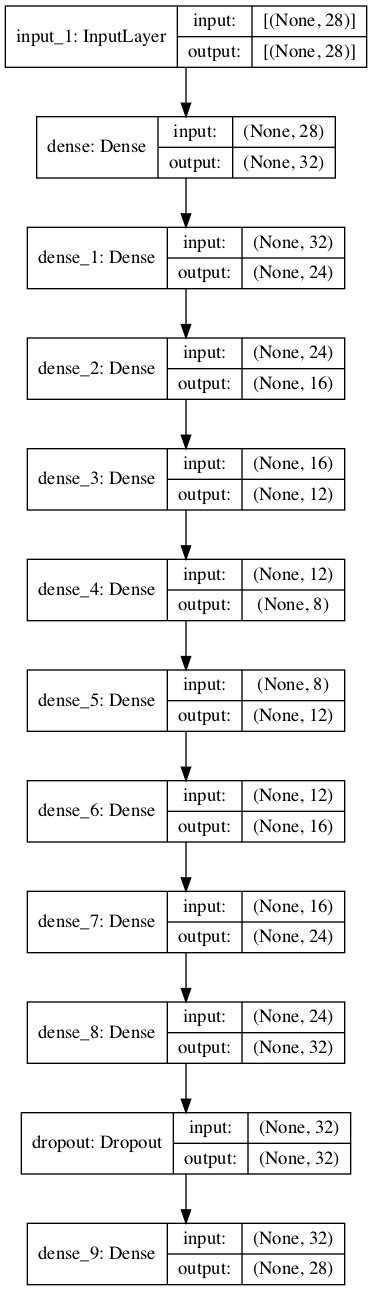

In [15]:

from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



In [16]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000)
%time \
hist = model.fit(data_train[:20000],\
                 data_train[:20000], \
                 epochs=3000,verbose=0,\
                 validation_split=.2,batch_size=1024,\
                 callbacks=[stop_early],shuffle=True)

CPU times: user 2min 37s, sys: 21.8 s, total: 2min 59s
Wall time: 1min 59s


### Training

Mean square error is used as loss as well as the gradient decent optimizer and a validation split of 20\%. We observe a step-like behavior of the loss during training. Also the loss and the validation loss look alike which leads us to the conclusion that the model does not overfit.

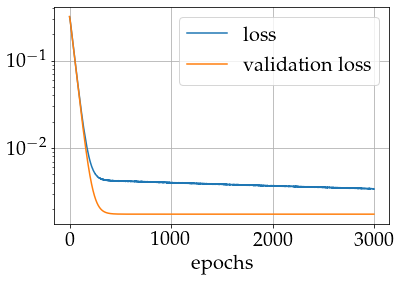

In [17]:
plt.semilogy(hist.history['loss'],label='loss')
plt.semilogy(hist.history['val_loss'],label='validation loss')
plt.xlabel('epochs')
plt.legend()
plt.grid()

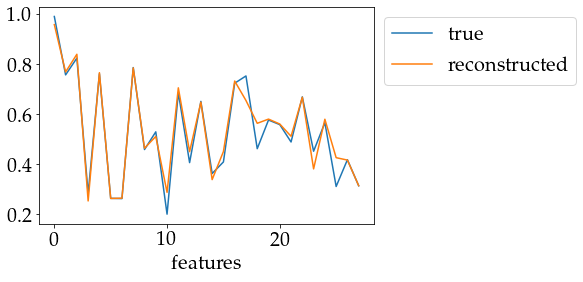

In [42]:
plt.plot(data_train[100:101].to_numpy().T,label='true')
plt.plot(model.predict(data_train[100:101]).T,label='reconstructed')
plt.xlabel('features')
plt.legend(bbox_to_anchor=(1,1))

In [24]:
model.save('creditCard_AE_model3');

/Users/birsigler/miniforge3/envs/python38/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Users/birsigler/miniforge3/envs/python38/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: creditCard_AE_model3/assets


Compare MSEs

In [43]:
mse_train = tf.keras.losses.mse(data_train,model.predict(data_train))

In [44]:
temp = data_fraud.drop(['Class','Time','Amount'],axis=1)

In [45]:
mse_fraud = tf.keras.losses.mse(temp,model.predict(temp))

MSE of the train data versus fraudulent data

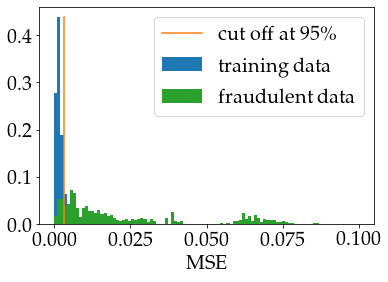

In [83]:
mse_hist = plt.hist(mse_train.numpy(),bins=np.linspace(0,.1,100),\
                    weights=np.ones(mse_train.numpy().shape)/mse_train.numpy().shape,\
                   label='training data')
th_95 = np.argmin(abs(mse_hist[0].cumsum()/mse_hist[0].sum() - .95))
plt.plot([mse_hist[1][th_95],mse_hist[1][th_95]],[0,mse_hist[0].max()],label='cut off at 95\%')

plt.hist(mse_fraud.numpy(),bins=np.linspace(0,.1,100),\
         weights=np.ones(mse_fraud.numpy().shape)/mse_fraud.numpy().shape,\
        label='fraudulent data')
plt.xlabel('MSE')
plt.legend()

Establish cut off beyond which data is treated as fraudulent

In [73]:
cut_off = mse_hist[1][th_95]

In [74]:
temp = data_test.drop(['Class','Time','Amount'],axis=1)
mse_test = tf.keras.losses.mse(temp,model.predict(temp))

Combine everything into a dataframe

In [75]:
test_results = pd.DataFrame({'Class': data_test['Class'].astype(int),\
                             'isFraud': 1*(mse_test >= cut_off).numpy()})

In [76]:
test_results['compare'] = 1*(test_results['Class'] == test_results['isFraud'])

In [77]:
test_results

,Class,isFraud,compare
8,0,0,1
13,0,0,1
20,0,0,1
22,0,0,1
25,0,0,1
...,...,...,...
284783,0,0,1
284788,0,0,1
284789,0,0,1
284796,0,0,1


In [78]:
non_fraud_Res = test_results[test_results['Class']==0]
fraud_Res = test_results[test_results['Class']==1]

Accuracy of non-fraudulent data

In [79]:
sum(non_fraud_Res['compare'])/non_fraud_Res['compare'].shape[0]

0.9030125037370522

Accuracy of fraudulent data

In [80]:
sum(fraud_Res['compare'])/fraud_Res['compare'].shape[0]

0.8780487804878049

Accuracy of all test data

In [81]:
sum(test_results['compare'])/test_results['compare'].shape[0]

0.9027983610844739